In [85]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from fnsa.classifier.data import load as load_data
from fnsa.classifier.util import cross_validate, evaluate, plot_confusion_matrix

from sklearn.externals import joblib

In [87]:
from fnsa.feature import FeatureExtractor
from fnsa.lexicon import Lexicon
from fnsa.scope import DRScopeDetector, IFScopeDetector
#from fnsa.graph import make_graph
from fnsa.util import show, show_tree
import spacy

In [88]:
include_words = True

nlp = spacy.load('en_core_web_sm')
lexicon = Lexicon(nlp)
dr_detector = DRScopeDetector()
if_detector = IFScopeDetector()
extractor = FeatureExtractor(lexicon, detectors=[dr_detector, if_detector], include_words=include_words)

In [89]:
fname = 'all-agree'
if include_words: fname = 'all-agree-with-words'
model = 'nb'
codes = [-1, 0, 1]
code2sentiment = {-1:'-', 0:'=', 1:'+'}

path = './model/%s-%s.pkl' % (model, fname)
classifier = joblib.load(path)

In [90]:
def predict(classifier, sentence):
    doc, features = extractor(sentence)
    features = [token.lower() for token in features]
    print(" ".join(features))
    return classifier.predict(features)[0]
    
sentence = "The Group's operative EBIT will probably be negative."
predict(classifier, sentence)

the xe_org 's operative ebit fe_+_=_mod will if_mod probably if_mod be negative if_rev .


0

## Sentence-Level Sentiment Analysis of Financial News Test Dataset

Accuracy = 0.208.


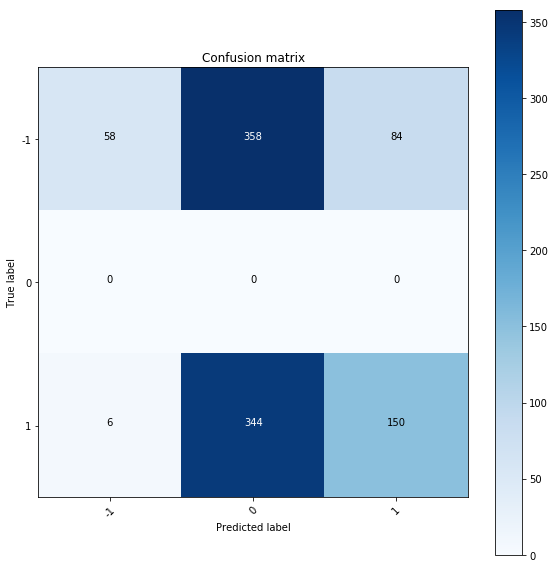

In [91]:
fname = 'ad-hoc'
if include_words: fname = '%s-with-words' % fname
sl_sentences, sl_X, sl_y = load_data(fname + ".tsv")
#sl_y = [-1 if code == 0 else 1 for code in sl_y]
accuracy, cm = evaluate(classifier, sl_X, sl_y)
plot_confusion_matrix(cm, codes)
print("Accuracy = %0.3f." % (accuracy,))

In [92]:
code2position = {-1:0, 0:1, 1:2}

def correct_confidence(classifier, X, y, index):
    x = X[index]
    probs = classifier.predict_proba([x])[0]
    position = code2position[y[index]]
    return probs[position]    

def show_classification_result(classifier, sentences, X, y, y_predicted, index):
    sentence = sentences[index]
    actual = code2sentiment[y[index]]
    predicted = code2sentiment[y_predicted[index]]
    print("%d [%s||%s] %s" % (index, predicted, actual, sentence))
    doc, features = extractor(sentence)
    show(doc, index=None, include_text=False, include_tree=False)
    print("<<%s>>" % X[index])
    show_tree(doc)


In [93]:
indices = range(len(sl_y))
indices = sorted(indices, key=lambda index: correct_confidence(classifier, sl_X, sl_y, index))

sl_y_predicted = classifier.predict(sl_X)

In [94]:
start = 100
stop = 110
for index in indices[start:stop]:
    show_classification_result(classifier, sl_sentences, sl_X, sl_y, sl_y_predicted, index)
    print('-----')

718 [=||-] On this basis, and after factoring in Porsche's debt, Volkswagen is expected to pay approximately up to EUR 3.3 billion for the 42.0 percent stake.
 On this basis , and after factoring in [Porsche/xe:org] 's debt , [Volkswagen/xe:org] is expected to pay [approximately/if:unc] [up/dr:+] to [EUR/xe:org] [3.3 billion/xe:car] for the [42.0 percent/xe:per] [stake/fe:+] .
<<on this basis , and after factoring in xe_org 's debt , xe_org is expected to pay approximately if_unc up dr_+ to xe_org xe_car for the xe_per stake fe_+_+_unc .>>
                          expected                                                       
     ________________________|____________________________                                
    |       |        On                                   |                              
    |       |    ____|_______                             |                               
    |       |   |    |     after                          |                              
  

In [ ]:
path = './model/nbsvm-%s.pkl' % fname
joblib.dump(classifier, path)
classifier_loaded = joblib.load(path)